In [25]:
### IMPORTS ###

# Quantum libraries:
import pennylane as qml
#from pennylane 
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import sys, os
import time
import copy
import tqdm
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool
import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")
##############


In [26]:
# My functions:
sys.path.insert(0, '../')
import vqe_functions as vqe
import qcnn_functions as qcnn


In [27]:
N = 8
J = 1


In [238]:
# Load data and separate in training and test set
data = joblib.load('../vqe_states_job/0noiseN'+str(N)+'.job')

#train_index = np.sort(np.random.choice(np.arange(len(data)), size=int(0.8*len(data)), replace=False ))
#train_index = np.sort(np.arange(len(data)//2, len(data)) )
train_index = np.sort(np.arange(len(data)//2) )

X_train, Y_train = [], []
X_test, Y_test   = [], []
X, Y             = [], []
for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
        X.append(data[i][0])
        Y.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        X.append(data[i][0])
        Y.append(data[i][1])
        
X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('CLEAN DATA:')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data)))
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))

CLEAN DATA:
______________________________
Size of Data Set: 100
Size of Training Set: 50
Size of Test Set    : 50


In [239]:
def anomaly_circuit_rot1(N, params, wires, index = 0):
    for spin in range(N):
        qml.RY(params[index + spin], wires = spin)
        
    return index + N

def anomaly_circuit_ent1(N, wires, wires_trash, shift = 0):
    # Connection between trash wires
    for wire, wire_next in zip(wires_trash[0::2], wires_trash[1::2]):
        qml.CZ(wires = [int(wire), int(wire_next)])
    for wire, wire_next in zip(wires_trash[1::2], wires_trash[2::2]):
        qml.CZ(wires = [int(wire), int(wire_next)])
        
    # Connections wires -> trash_wires
    for trash_idx, wire in enumerate(wires):
        trash_idx = 0 if trash_idx > len(wires_trash) else trash_idx
        qml.CZ(wires = [int(wire), wires_trash[trash_idx]])


def anomaly_circuit(N, vqe_circuit, vqe_params, params):
    # Number of wires that will not be measured |phi>
    n_wires = N//2 + N%2
    # Number of wires that will be measured |0>^k
    n_trash = N//2
    
    wires = np.concatenate((np.arange(0, n_wires//2 + n_wires%2), np.arange(N-n_wires//2,N) ))
    wires_trash = np.setdiff1d(np.arange(N), wires)

    vqe_circuit(N, vqe_params)
    qml.Barrier()
    qml.Barrier()
    index = anomaly_circuit_rot1(N, params, wires)
    anomaly_circuit_ent1(N, wires, wires_trash)
    qml.Barrier()
    index = anomaly_circuit_rot1(N, params, wires, index)
    anomaly_circuit_ent1(N, wires, wires_trash)
    qml.Barrier()
    index = anomaly_circuit_rot1(N, params, wires, index)
    
    return wires_trash, index

In [210]:
_, n_params = anomaly_circuit(N, vqe.vqe_circuit, X_train[0], [0]*100)

In [211]:
device = qml.device("default.qubit.jax", wires = N, shots = None)


In [249]:
def train_encoder(epochs, lr, N, device, vqe_circuit, X_train, X_test, train_index, plot = True, info = True, circuit = False):
    #X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)

    @qml.qnode(device, interface="jax")
    def encoder_circuit(N, vqe_circuit, vqe_params, params):
        wires_trash, _ = anomaly_circuit(N, vqe_circuit, vqe_params, params)

        # return <psi|H|psi>
        return [qml.expval(qml.PauliZ(k)) for k in wires_trash]
    
    v_encoder_circuit = jax.vmap(lambda p, x: encoder_circuit(N, vqe_circuit, x, p), in_axes = (None, 0) )
    
    def compress(params, vqe_params):
        return jnp.sum(1 - v_encoder_circuit(params, vqe_params) )/(2*len(vqe_params))
    
    if info:
        print('+--- PARAMETERS ---+')
        print('lr     = {0} (learning rate)'.format(lr) )
        print('epochs = {0} (# epochs for learning)'.format(epochs) )
        print('N      = {0} (Number of spins of the system)'.format(N) )
        
    wires_trash, n_params = anomaly_circuit(N, vqe.vqe_circuit, X_train[0], [0]*100)
    
    if circuit:
        print('+-- CIRCUIT ---+')
        drawer = qml.draw(anomaly)
        print(drawer(N, vqe.vqe_circuit, [0]*len(X_train[0]), np.arange(n_params)) )
    
    jd_compress     = jax.jit(jax.grad(lambda p: compress(p, X_train)) )
    j_compress      = jax.jit(lambda p: compress(p, X_train))
    get_compression = jax.jit(lambda p: jnp.sum(v_encoder_circuit(p, X_train),axis=1)/len(wires_trash) )
    
    if len(X_test) > 0:
        j_compress_test = jax.jit(lambda p: compress(p, X_train))
        get_compression_test = jax.jit(lambda p: jnp.sum(v_encoder_circuit(p, X_test),axis=1)/len(wires_trash) )
    
    params = np.random.rand(n_params)
    
    loss = []
    progress = tqdm.tqdm(range(epochs), position=0, leave=True)
    for epoch in range(epochs):
        params -= lr*jd_compress(params)
        
        if (epoch+1) % 100 == 0:
            loss.append(j_compress(params))
            progress.set_description('Cost: {0}'.format(loss[-1]) )
        progress.update(1)

    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(16,5))
        
        ax[0].scatter(train_index, get_compression(params), label = 'Training')
        if len(X_test) > 0:
            ax[0].scatter(np.setdiff1d(np.arange(len(X_train)+len(X_test)), train_index), get_compression_test(params) , label = 'Test')
        ax[0].axvline(x=len(data)//2, color='red', linestyle='--')    
        ax[0].legend()
        ax[0].grid(True)
        
        ax[1].set_title('Loss of the encoder')
        ax[1].plot(np.arange(len(loss))*100, loss)
        
        
    return params

In [250]:
epochs = 10000
lr = 0.01


+--- PARAMETERS ---+
lr     = 0.01 (learning rate)
epochs = 10000 (# epochs for learning)
N      = 8 (Number of spins of the system)


Cost: 0.036106791347265244: 100%|████████| 10000/10000 [00:25<00:00, 395.38it/s]


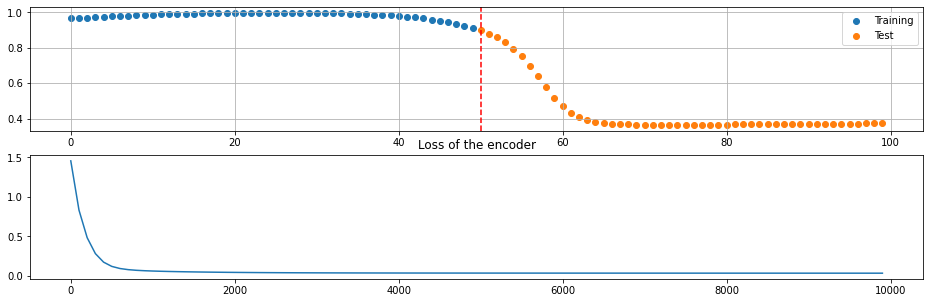

In [251]:
params = train_encoder(epochs, lr, N, device, vqe.vqe_circuit, X_train, X_test, train_index, plot = True, info = True, circuit = False)